In [2]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)

import matplotlib.pyplot as ply
plt.style.use('ggplot')

In [3]:
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)
len(tfms)

2

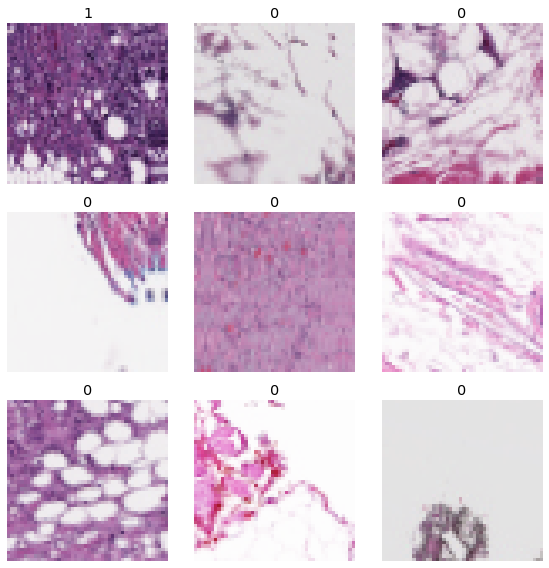

In [4]:

path = '/content/drive/My Drive/cancer detection/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=48, bs=128).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(8,8))

In [5]:
# Training and validation set splits
data.label_list

LabelLists;

Train: LabelList (2405 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/cancer detection;

Valid: LabelList (601 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,0,0,0,0
Path: /content/drive/My Drive/cancer detection;

Test: None

In [6]:
from collections import Counter

In [7]:
# Training set
train_counts = Counter(data.train_ds.y)
train_counts.most_common()

[(Category 0, 1976), (Category 1, 429)]

In [8]:
# Validation set
valid_counts = Counter(data.valid_ds.y)
valid_counts.most_common()

[(Category 0, 468), (Category 1, 133)]

In [10]:
# Initializing the custom class weights and pop it to the GPU
from torch import nn

weights = [0.4, 1]
class_weights=torch.FloatTensor(weights).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.041943,0.479216,0.793677,09:42
1,0.877356,0.448462,0.830283,00:23
2,0.723164,0.319656,0.890183,00:07
3,0.616352,0.318448,0.901830,00:07
4,0.549885,0.295879,0.911814,00:07


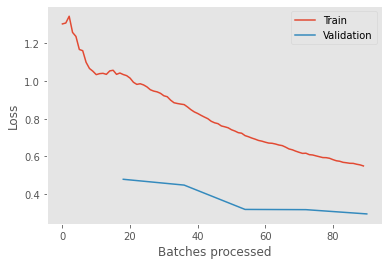

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy]).to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

In [12]:
# Saving the model
learn.save('stage-1-rn50')

In [13]:
# Model's final validation loss and accuracy
learn.validate()

[0.29587948, tensor(0.9118)]

In [14]:

# Model's final training loss and accuracy
learn.validate(learn.data.train_dl)

[0.3284341, tensor(0.8650)]

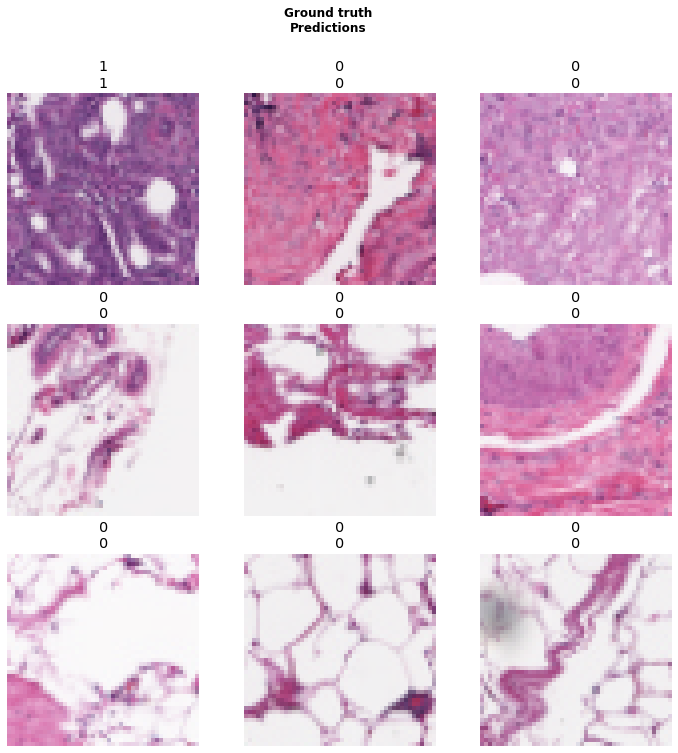

In [15]:
# Looking at model's results
learn.show_results(rows=3)

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

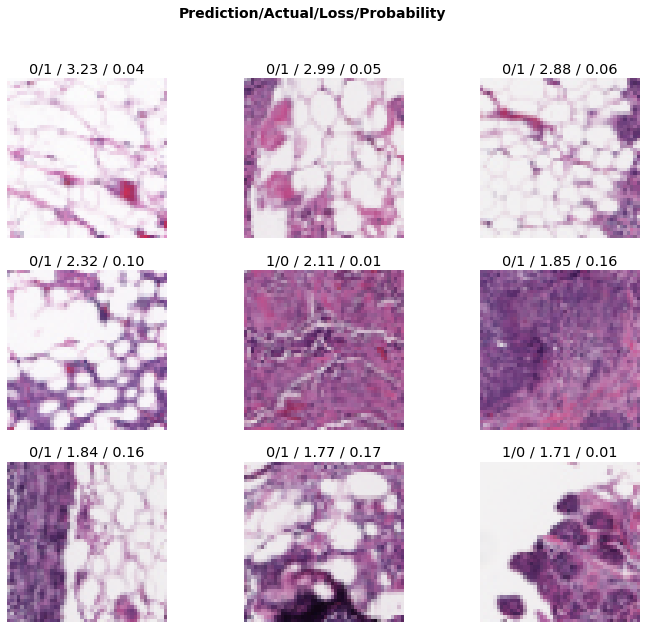

In [17]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

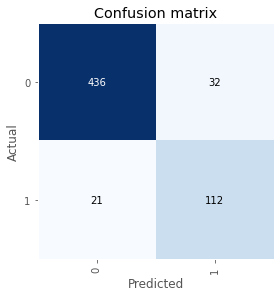

In [18]:
interp.plot_confusion_matrix()

In [19]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    
    ground_truth = []
    pred_labels = []

    for i in range(len(learn.data.valid_ds)):
        temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
        temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
        pred_labels.append(temp_pred)
        ground_truth.append(temp_truth)

    assert len(pred_labels) == len(ground_truth)
    
    return classification_report(ground_truth, pred_labels, target_names=data.classes)

In [20]:
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       468
           1       0.78      0.84      0.81       133

    accuracy                           0.91       601
   macro avg       0.87      0.89      0.88       601
weighted avg       0.92      0.91      0.91       601



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


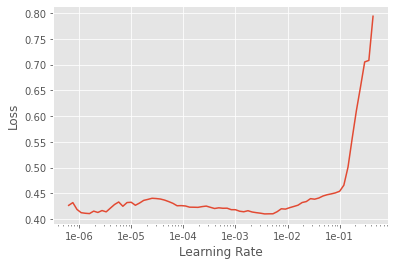

In [21]:
learn.lr_find();
learn.recorder.plot()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-04, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.403802,0.287643,0.916805,00:08
1,0.399121,0.287826,0.910150,00:07


In [23]:
# Save model
learn.save('stage-2-more-rn50')

In [24]:
# Looking at the classification report 
print(return_classification_report(learn))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       468
           1       0.77      0.84      0.81       133

    accuracy                           0.91       601
   macro avg       0.86      0.89      0.87       601
weighted avg       0.91      0.91      0.91       601



In [25]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 24, 24]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
ReLU                 [64, 24, 24]         0          False     
______________________________________________________________________
MaxPool2d            [64, 12, 12]         0          False     
______________________________________________________________________
Conv2d               [64, 12, 12]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 12, 12]         128        True      
______________________________________________________________________
Conv2d               [64, 12, 12]         36,864     True      
___________________________________________________

In [26]:
learn.export('breast-cancer-rn50.pkl')